In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import itertools, operator, random, math
from scipy.sparse.linalg import spsolve_triangular
from sklearn import linear_model
import utils as ut
import pandas as pd
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [8]:
def rym(t, pop):
    L, S= pop
    ktrsc, kdeA, kpolyA, kdgrd = 1, 0.5, 0.5, 0.2
    AdeA, ApolyA, Adgrd = 0.8, 0.8, 0.5
    pdeA, ppolyA, pdgrd = 6, 18, 0


    Ktrsc = ktrsc
    KdeA = kdeA*(1+AdeA*(np.cos(2*np.pi*((t - pdeA)%24)/24)))
    KpolyA = kpolyA*(1+ApolyA*(np.cos(2*np.pi*((t - ppolyA)%24)/24)))
    Kdgrd = kdgrd*(1+Adgrd*(np.cos(2*np.pi*((t - pdgrd) %24)/24)))

    dL = Ktrsc - KdeA*L + KpolyA*S
    dS = KdeA*L - KpolyA*S - Kdgrd*S

    dpop = np.array([dL, dS])
    return dpop

In [12]:
dt, pts = 0.01, int(120/0.01)
tspan = np.linspace(dt, 240, num=pts)
pop0 = [1,5]
pop1 = [20,6]
pop2 = [3, 10]
pop3 = [0.1, 10]
pop4 = [10, 0.5]

sol1 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop0, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol1 = rym(sol1.t, sol1.y)

sol2 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop1, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol2 = rym(sol2.t, sol2.y)

sol3 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop2, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol3 = rym(sol3.t, sol3.y)

sol4 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop3, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol4 = rym(sol4.t, sol4.y)

sol5 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop4, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol5 = rym(sol5.t, sol5.y)

In [13]:
pop_data_std = np.hstack([sol1.y, sol2.y, sol3.y, sol4.y, sol5.y])
dpop_data_std = np.hstack([dsol1, dsol2, dsol3, dsol4, dsol5])

In [17]:
dpop1 = ut.time_different(dt,dsol1, sol1.y)
dpop2 = ut.time_different(dt,dsol2, sol2.y)
dpop3 = ut.time_different(dt,dsol3, sol3.y)
dpop4 = ut.time_different(dt,dsol4, sol4.y)
dpop5 = ut.time_different(dt,dsol5, sol5.y)
dpop_data = np.hstack([dpop1, dpop2, dpop3,dpop4, dpop5])

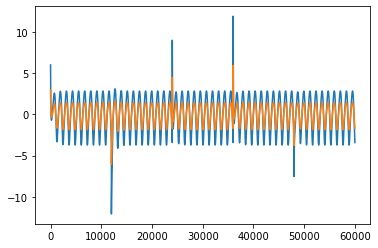

In [20]:
plt.plot(dpop_data[0])
plt.plot(dpop_data_std[0])

In [21]:
tspan_ = []
for i in range(5):
    tspan_.extend(tspan.flatten())

In [22]:
A_array = [ 0.2, 0.5, 0.8, 1]
k_array = [0.2, 0.5, 0.8, 1]
p_array = [0, 6, 12, 18]

u_matrix = np.array([], dtype=np.float).reshape(len(tspan_), 0)
lab_name = []
for i in k_array:
    for j in A_array:
        for k in p_array:
            tmp = 2*np.pi*((np.array(tspan_) - k) % 24)/24
            k_ = i*(1+j*np.cos(tmp)).reshape(-1, 1)
            u_matrix  = np.hstack([u_matrix, k_.reshape(-1,1)])
            lab_name.append("p:{0} A:{1} k:{2}".format(str(k), str(j), str(i)))

In [23]:
one_vec = np.ones((len(tspan_),1))
theta_inital = np.hstack([one_vec, pop_data[0].reshape(-1,1), pop_data[1].reshape(-1,1)])
theta_ = np.hstack([theta_inital, u_matrix * one_vec, u_matrix*pop_data[0].reshape(-1,1), u_matrix*pop_data[1].reshape(-1,1)])


In [24]:
clf = linear_model.Lasso(alpha=1e-3, fit_intercept=False, max_iter=1e5)
clf.fit(theta_,dpop_data.T)
Xi = clf.coef_

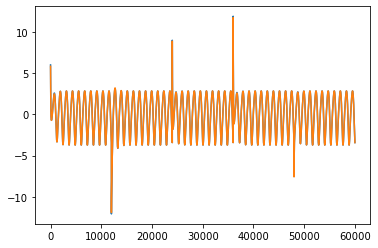

In [25]:
x = theta_.dot(Xi.T)
plt.plot(dpop_data[0])
plt.plot(x[:,0])

In [26]:
indL,  = np.where(abs(Xi[0]) > 0.1)
indS, = np.where(abs(Xi[1]) > 0.1)

In [98]:
print(Xi[0,indL])
print(indL)

[ 0.11028102  0.05307367  0.19421065  0.05594462  0.15067891 -0.1390931
 -0.1653814  -0.15620931  0.07934284  0.16326045  0.25388647]
[  0  59  60  63  64 108 112 128 186 190 194]


In [94]:
print('[1] * K')
print(lab_name[60-3])
print(lab_name[64-3])
print('[L] * K')
print(lab_name[108-67])
print(lab_name[112-67])
print(lab_name[128-67])
print('[S] * K')
print(lab_name[190-67-64])
print(lab_name[194-67-64])

[1] * K
p:6 A:0.8 k:1
p:6 A:1 k:1
[L] * K
p:6 A:0.8 k:0.8
p:6 A:1 k:0.8
p:6 A:1 k:1
[S] * K
p:18 A:0.8 k:1
p:18 A:1 k:1


In [108]:
print(Xi[1,indS])
print(indS)

[ 0.14605115  0.22227978 -0.1340295  -0.15074364 -0.25359641]
[124 128 179 190 194]


In [109]:
print('[L] * K')
print(lab_name[124-67])
print(lab_name[128-67])
print('[S] * K')
print(lab_name[179-67-64])
print(lab_name[190-67-64])
print(lab_name[194-67-64])

[L] * K
p:6 A:0.8 k:1
p:6 A:1 k:1
[S] * K
p:0 A:0.2 k:1
p:18 A:0.8 k:1
p:18 A:1 k:1
